# Sparkify Project 

## Project Overview

The purpose of this project is to understand and predict customer churn for Sparkify (online music streaming service) by analyzing available online customer journey data and using it in the devleopment of ML solution.

## Problem Statement

Understanding and being able to predict customer churn is highly important for the companies. Knowing, which customer is more likely to Churn, company can react and propose incentives to keep the customer. Customer retention is one of the key areas of marketing. Moreover, retaining customer is usually much cheaper than acquiring a new customer, hence, being able to understand and predict customer churn is crucial for the company to be profitable and successful.

## Metrics

To measure the performance of the churn prediction, f1 score - a harmonized mean of precision and recall will be used as it is important for us not only to accurately predict customers who are about to churn, but also to avoid false positives as we want to avoid providing unnecessary incentives and marketing investment into customers who are not going to churn in reality.

## Definition

Churned customer is a customer who cancels the service subscription

## Data

The data to be analyzed is available on Udacity's workspace. file: mini_sparkify_event_data.json

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col , column
from pyspark.sql.types import DateType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import f1_score

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('ps').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')

In [4]:
print(f'Number of rows: {df.count()} Number of attributes: {len(df.columns)}')

Number of rows: 286500 Number of attributes: 18


In [5]:
print(f'List of attributes: {df.columns}')

List of attributes: ['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


# Data Overview

## Missing data

In [6]:
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    Input:
    - spark_df - pyspark data frame
    Output:
    - data frame with missing values
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

count_missings(df)

,count
artist,58392
length,58392
song,58392
firstName,8346
gender,8346
userAgent,8346
lastName,8346
location,8346
registration,8346
sessionId,0


In [7]:
table = df.createOrReplaceTempView('table')
spark.sql("select distinct auth, count(1) as count from table where userAgent is null group by auth").toPandas()

,auth,count
0,Logged Out,8249
1,Guest,97


Looking at the missing data, I see that the most important information is there, no missing userIds or session ids. The other none points can be explained by the fact that most of the entries miss at the point when user logs out, which is expected, hence, normal and doesn't require any actions

## Data Types

In [8]:
df.first()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [9]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

All of the variables are of type string, hence some variables have inapropriate datatype that have to be changed.

In [10]:
# Select columns per type to be transformed into
integers = ["itemInSession","registration","sessionId","userId","status", "ts"]
floats = ["length"]

# Run the type transformation

for c in integers:
    df = df.withColumn(c, col(c).cast('integer'))
    
for c in floats:
    df = df.withColumn(c, col(c).cast('float'))

There is also ts column which seems to be a data frame, which I want to cast into datetime format

In [11]:
# Cast ts into date type
df = df.withColumn('date',  F.from_unixtime('ts').cast(DateType()))

In [12]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: integer (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: float (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: integer (nullable = true)
 |-- sessionId: integer (nullable = true)
 |-- song: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- ts: integer (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- date: date (nullable = true)



# Exploratory Data Analysis

### Summary statistics

In [23]:
stats = df.select(['itemInSession', 'length' ]).describe().toPandas()
stats

,summary,itemInSession,length
0,count,286500,228108
1,mean,114.41421291448516,249.11718195785375
2,stddev,129.76726201140994,99.23517961294256
3,min,0,0.78322
4,max,1321,3024.6658


### Identifying Churned Customers

As mentioned in the definition part of the introduction, Churned customer is a customer who cancelled the subscription. Churn flag will be added to the data set

In [32]:
pages = spark.sql("Select page, count(distinct userId) as userId_count from df group by page").toPandas()
pages

,page,userId_count
0,Cancel,52
1,Submit Downgrade,49
2,Thumbs Down,203
3,Home,223
4,Downgrade,154
5,Roll Advert,207
6,Logout,213
7,Save Settings,132
8,Cancellation Confirmation,52
9,About,155


In [33]:
df.createOrReplaceTempView('df')
churned = spark.sql("Select distinct userId as id from df where page = 'Cancellation Confirmation'")
churned = churned.withColumn('Churn', F.lit(1))
churned.show(5)

+------+-----+
|    id|Churn|
+------+-----+
|200001|    1|
|    53|    1|
|100003|    1|
|200021|    1|
|100007|    1|
+------+-----+
only showing top 5 rows



In [34]:
df = df.join(churned, df.userId == churned.id, how = 'left')
df.first()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.8901672363281, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=575070032, sessionId=29, song='Rockpools', status=200, ts=753825032, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId=30, date=datetime.date(1993, 11, 20), id=None, Churn=None)

In [35]:
df = df.fillna(0, subset = 'Churn')
df = df.drop('id')
df.first()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.8901672363281, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=575070032, sessionId=29, song='Rockpools', status=200, ts=753825032, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId=30, date=datetime.date(1993, 11, 20), Churn=0)

### Summary statistics per churned and non-churned customers

In [37]:
df.createOrReplaceTempView('df')
stats_churn = spark.sql("Select Churn, mean(itemInSession) as itemInSession_mean, \
std(itemInSession) as itemInSession_stdev, \
min(itemInSession) as itemInSession_min, \
max(itemInSession) as itemInSession_max, \
mean(length) as length_mean, \
std(length) as length_stdev, \
min(length) as length_min, \
max(length) as length_max from df group by Churn").toPandas()
stats_churn

,Churn,itemInSession_mean,itemInSession_stdev,itemInSession_min,itemInSession_max,length_mean,length_stdev,length_min,length_max
0,1,109.23,122.72,0,889,248.63,102.38,4.05,"3,024.67"
1,0,115.38,131.01,0,1321,249.21,98.63,0.78,"3,024.67"


Here, we can observe that churned customers, usually, have fewer items per session on average than non-churned customers, as well as lower maximum amount of sessions per session. Those insights could indicate that churning customers are less active when it comes to app usage comparing to non-churned users, however, the difference is not drastic. For the rest the numbers are pretty much identical, except for the fact that minimum length is 4 seconds higher for churned vs non-churned users.

## Churn analysis and feature engineering

### Gender

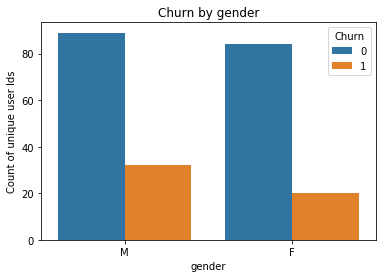

In [38]:
df.createOrReplaceTempView('df')
gender = spark.sql('select count(distinct userId) as count, gender, Churn from df group by gender, Churn').toPandas().dropna()
sns.barplot(data = gender, x ='gender', y = 'count', hue = 'Churn')
plt.title('Churn by gender')
plt.ylabel('Count of unique user Ids')
plt.show()

Male users have a slightly higher chance to churn than women

### State

In [39]:
df = df.withColumn('State',F.substring('location',-2,2))
df.first()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.8901672363281, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=575070032, sessionId=29, song='Rockpools', status=200, ts=753825032, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId=30, date=datetime.date(1993, 11, 20), Churn=0, State='CA')

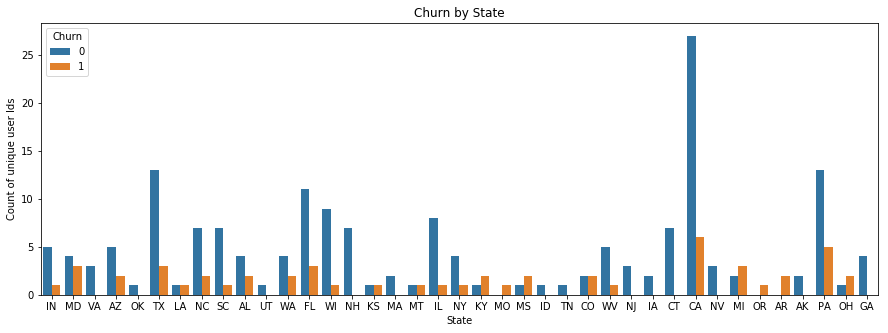

In [40]:
df.createOrReplaceTempView('df')
location = spark.sql('select State, Churn, count(distinct userId) as count from df \
group by State, Churn').toPandas().dropna()
plt.figure(figsize = (15,5))
sns.barplot(data = location, x ='State', y = 'count', hue = 'Churn')
plt.ylabel('Count of unique user Ids')
plt.title('Churn by State')
plt.show()

Some states have very high churn levels

### Device

In [41]:
df = df.withColumn('device', F.split(F.split(col('userAgent'),' \(').getItem(1),';').getItem(0))
df.first()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.8901672363281, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=575070032, sessionId=29, song='Rockpools', status=200, ts=753825032, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId=30, date=datetime.date(1993, 11, 20), Churn=0, State='CA', device='Windows NT 6.1')

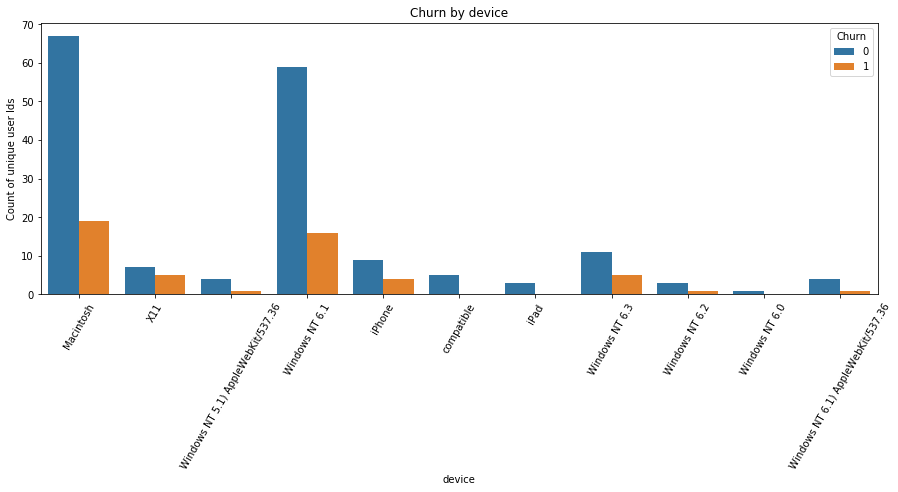

In [42]:
df.createOrReplaceTempView('df')
xx = spark.sql('select device, Churn, count(distinct userId) as count from df \
group by device, Churn').toPandas()
plt.figure(figsize = (15,5))
sns.barplot(data = xx, x ='device', y = 'count', hue = 'Churn')
plt.ylabel('Count of unique user Ids')
plt.title('Churn by device')
plt.xticks(rotation = 60)
plt.show()

X11 has the highest rate of churn followed by iPhone and Windows NT 6.3 device

### Pages

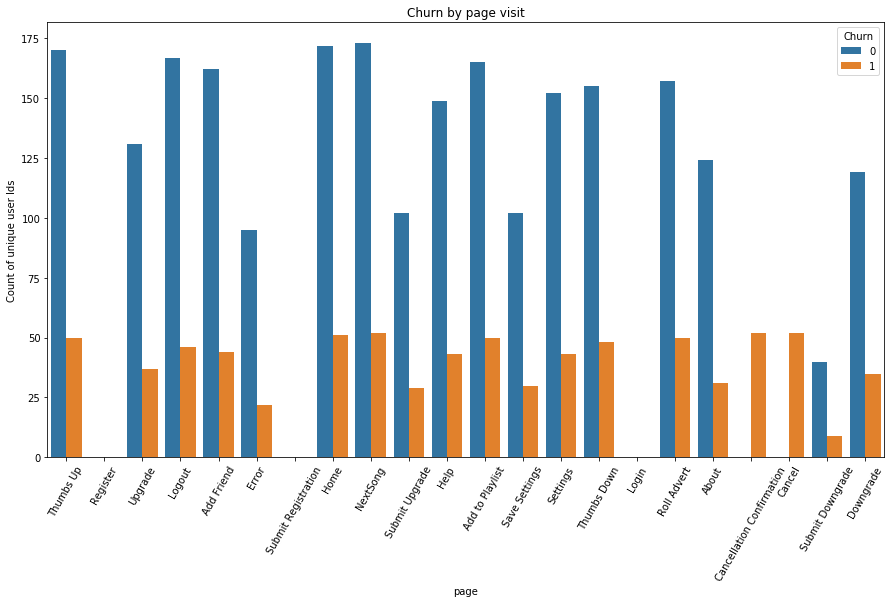

In [43]:
pages = spark.sql('select page,Churn, count(distinct userId) as count from df group by page, Churn').toPandas()
plt.figure(figsize = (15,8))
sns.barplot(data = pages, x = 'page', y ='count', hue = 'Churn')
plt.ylabel('Count of unique user Ids')
plt.title('Churn by page visit')
plt.xticks(rotation = 60)
plt.show()

### Usage stats per userId

In [54]:
df.createOrReplaceTempView('df')
dfagg = spark.sql('select count(song)/datediff(max(date),min(date)) as avg_songs_day, \
count(artist)/datediff(max(date),min(date)) as avg_artist_day, \
count(distinct song)/datediff(max(date),min(date)) as avg_songs_dist_day, \
count(distinct artist)/datediff(max(date),min(date)) as avg_artist_dist_day, \
sum(length)/datediff(max(date),min(date)) as length_day, \
max(length) as max_length, \
min(length) as min_length, \
(sum(length)/count(song))/datediff(max(date),min(date)) as length_day_song, \
count(distinct sessionId)/datediff(max(date),min(date)) as session_day, \
count(page)/datediff(max(date),min(date)) as page_visit_day, \
mean(itemInSession) as avg_item_session, \
max(itemInSession) as max_item_session, \
userId, Churn from df \
group by userId, Churn').toPandas()

In [55]:
dfagg.head().T

,0,1,2,3,4
avg_songs_day,0.08,0.09,0.03,0.05,0.02
avg_artist_day,0.08,0.09,0.03,0.05,0.02
avg_songs_dist_day,0.07,0.08,0.03,0.04,0.02
avg_artist_dist_day,0.06,0.07,0.02,0.03,0.02
length_day,19.42,21.12,7.86,11.36,5.92
max_length,"1,959.00",967.37,"2,015.79","3,024.67","1,400.27"
min_length,27.01,22.05,11.94,7.84,38.35
length_day_song,0.03,0.02,0.01,0.01,0.01
session_day,0.00,0.00,0.00,0.00,0.00
page_visit_day,0.09,0.10,0.04,0.05,0.03


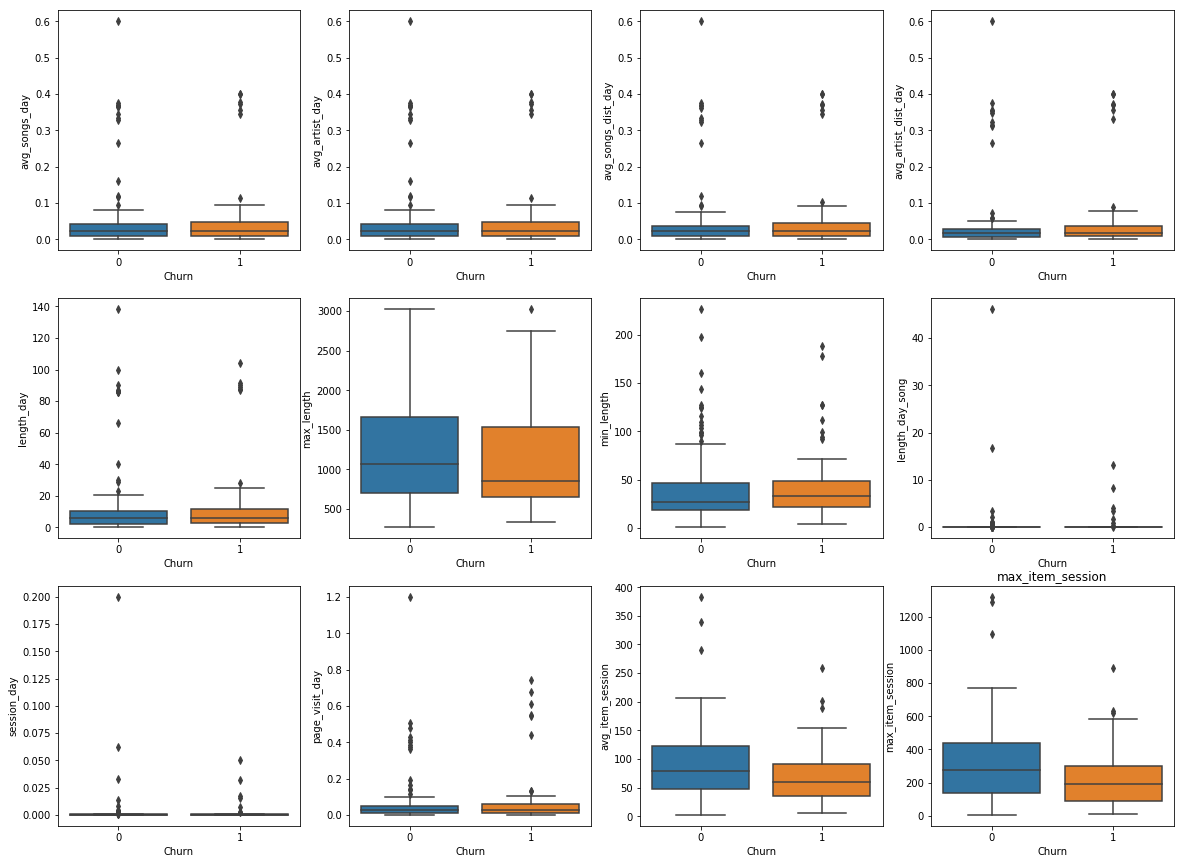

In [56]:
_,axes = plt.subplots(3,4, figsize = (20,15), sharey = False)
x = 0
y = 0
for c in dfagg.drop(columns = ['Churn', 'userId']).columns:
    if x == 4 and y == 0:
        y = 1
        x = 0
    elif x == 4 and y == 1:
        y = 2
        x = 0
            
    sns.boxplot(data = dfagg, x = 'Churn', y = c, ax = axes[y,x])
    plt.title(c)
      
    x += 1
    
plt.show()

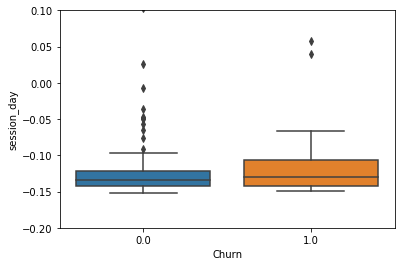

In [48]:
sns.boxplot(data = dfsc, x = 'Churn', y = 'session_day')
plt.ylim(-0.2,0.1)
plt.show()

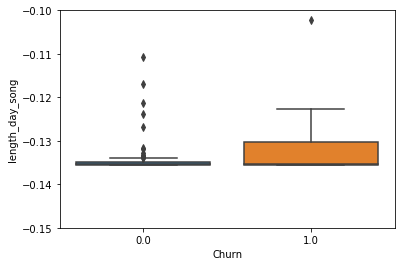

In [49]:
sns.boxplot(data = dfsc, x = 'Churn', y = 'length_day_song')
plt.ylim(-0.15,-0.1)
plt.show()

# Feature Engineering


In [57]:
# Get State feature
df = df.withColumn('state',F.substring('location',-2,2))

# Get device feature
df = df.withColumn('device', F.split(F.split(col('userAgent'),' \(').getItem(1),';').getItem(0))

### Create aggregated over time features

In [70]:
df.createOrReplaceTempView('df')
dfagg = spark.sql('select count(song)/datediff(max(date),min(date)) as avg_songs_day, \
count(artist)/datediff(max(date),min(date)) as avg_artist_day, \
count(distinct song)/datediff(max(date),min(date)) as avg_songs_dist_day, \
count(distinct artist)/datediff(max(date),min(date)) as avg_artist_dist_day, \
sum(length)/datediff(max(date),min(date)) as length_day, \
max(length) as max_length, \
min(length) as min_length, \
(sum(length)/count(song))/datediff(max(date),min(date)) as length_day_song, \
count(distinct sessionId)/datediff(max(date),min(date)) as session_day, \
count(page)/datediff(max(date),min(date)) as page_visit_day, \
mean(itemInSession) as avg_item_session, \
max(itemInSession) as max_item_session, \
userId as id, gender from df \
group by userId, gender')

### Join both data frames

In [71]:
df_input = spark.sql('select distinct userId, Churn, state, device from df')
df_input = df_input.fillna('None')
dfagg = dfagg.fillna(-0.9999)

In [72]:
df_input = df_input.join(dfagg, df_input.userId == dfagg.id, how = 'left')
df_input.first()

Row(userId=148, Churn=0, state='FL', device='Windows NT 6.1', avg_songs_day=0.00881057268722467, avg_artist_day=0.00881057268722467, avg_songs_dist_day=0.008456378810351316, avg_artist_dist_day=0.007747991056604609, length_day=2.16494058258514, max_length=978.4420166015625, min_length=22.4648494720459, length_day_song=0.005439549202475226, session_day=0.00026564540765501517, page_visit_day=0.011467026763774821, avg_item_session=45.08687258687259, max_item_session=171, id=148, gender='M')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Prepare train and test data sets

In [73]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

In [75]:
catcols = ['state','device', 'gender']

num_cols = ['avg_songs_day',
           'avg_artist_day', 'avg_songs_dist_day', 'avg_artist_dist_day',
           'length_day', 'length_day_song', 'session_day', 'page_visit_day',
           'avg_item_session','max_item_session', 'max_length','min_length']

labelCol = 'Churn'

data = get_dummy(df_input.drop('userId','id').dropna(),catcols,num_cols,labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(61,[3,39,48,49,5...|    0|
|(61,[0,38,48,49,5...|    0|
|(61,[1,38,48,49,5...|    0|
|(61,[11,42,48,49,...|    0|
|(61,[15,39,48,49,...|    1|
+--------------------+-----+
only showing top 5 rows



In [76]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [77]:
trainingData.count()

162

## RF model

In [78]:
# Initialize Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Set up the pipeline
pipeline = Pipeline(stages=[rf])

# Train the model
model = pipeline.fit(trainingData)

# Predict on test data
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("features","label","prediction").show(5)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(61,[3,39,48,49,5...|    0|       0.0|
|(61,[25,38,48,49,...|    1|       0.0|
|(61,[0,40,48,49,5...|    0|       1.0|
|(61,[30,40,49,50,...|    1|       0.0|
|(61,[1,44,49,50,5...|    0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows



In [109]:
def f1score(predicted):
    """
    - Input:
    predictions - output of the model prediction results on testData
    
    - Output:
    f1_score per threshold cut
    """
    
    proba = predicted.select('probability').toPandas()
    y_true = predicted.select('label').toPandas()
    churn_proba = [x[1] for x in proba.probability]
        
    for i in range(0,10,1):
        y_pred = [1 if x > i/10 else 0 for x in churn_proba]
        print(f'F1 score {np.round(f1_score(y_true, y_pred),2)} with threshold = {i/10}')

In [107]:
f1score(predictions)

F1 score 0.27 with threshold = 0
F1 score 0.27 with threshold = 1
F1 score 0.3 with threshold = 2
F1 score 0.31 with threshold = 3
F1 score 0.22 with threshold = 4
F1 score 0.12 with threshold = 5
F1 score 0.0 with threshold = 6
F1 score 0.0 with threshold = 7
F1 score 0.0 with threshold = 8
F1 score 0.0 with threshold = 9


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Grid Search RF model

In [85]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[rf])

paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 30])\
                            .addGrid(rf.maxDepth, [5,10,15]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) 

cvModel = crossval.fit(trainingData)

In [103]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[0]
bestParams = bestModel.extractParamMap()
bestParams

{Param(parent='RandomForestClassifier_b60281d4e241', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_b60281d4e241', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_b60281d4e241', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_b60281d4e241', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_b60281d4e241', 

In [112]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth = 5, numTrees = 30)
pipeline = Pipeline(stages=[rf])
model_tuned = pipeline.fit(trainingData)
pred_rf_tuned = model_tuned.transform(testData)
f1score(pred_rf_tuned)

F1 score 0.27 with threshold = 0
F1 score 0.27 with threshold = 1
F1 score 0.29 with threshold = 2
F1 score 0.43 with threshold = 3
F1 score 0.3 with threshold = 4
F1 score 0.12 with threshold = 5
F1 score 0.0 with threshold = 6
F1 score 0.0 with threshold = 7
F1 score 0.0 with threshold = 8
F1 score 0.0 with threshold = 9


### Conclusion

After running grid search with 2 fold cross validation, the best parameters for RF Classifier are:
numTrees = 30 and maxDepth = 5 with threshold of 0.3


## Gradient-Boosted Tree Classifier


In [113]:
from pyspark.ml.classification import GBTClassifier

In [114]:
# Initialize the classifier
gbtc = GBTClassifier(labelCol="label", featuresCol="features")

# Create pipeline
pipeline_gbtc = Pipeline(stages=[gbtc])

# Train the model
model_gbtc = pipeline_gbtc.fit(trainingData)

# Predict on test data
predictions_gbtc = model_gbtc.transform(testData)

# Select example rows to display
predictions_gbtc.select("features","label","prediction").show(5)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(61,[3,39,48,49,5...|    0|       0.0|
|(61,[25,38,48,49,...|    1|       0.0|
|(61,[0,40,48,49,5...|    0|       0.0|
|(61,[30,40,49,50,...|    1|       0.0|
|(61,[1,44,49,50,5...|    0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows



In [116]:
f1score(predictions_gbtc)

F1 score 0.27 with threshold = 0
F1 score 0.38 with threshold = 1
F1 score 0.41 with threshold = 2
F1 score 0.38 with threshold = 3
F1 score 0.26 with threshold = 4
F1 score 0.3 with threshold = 5
F1 score 0.3 with threshold = 6
F1 score 0.32 with threshold = 7
F1 score 0.25 with threshold = 8
F1 score 0.15 with threshold = 9


### Grid Search GBT model

In [ ]:
gbtc = GBTClassifier(labelCol="label", featuresCol="features")
pipeline_gbtc = Pipeline(stages=[gbtc])

paramGrid = ParamGridBuilder().addGrid(gbtc.maxIter, [20, 30, 50])\
                            .addGrid(gbtc.maxDepth, [5,10,15]).build()

crossval = CrossValidator(estimator=pipeline_gbtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) 

cvModel = crossval.fit(trainingData)

In [ ]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[0]
bestParams = bestModel.extractParamMap()
bestParams

In [121]:
gbtc = GBTClassifier(labelCol="label", featuresCol="features", maxIter = 30, maxDepth = 5)
pipeline_gbtc = Pipeline(stages=[gbtc])
model_tuned = pipeline.fit(trainingData)
pred_gbtc_tuned = model_tuned.transform(testData)
f1score(pred_gbtc_tuned)

F1 score 0.27 with threshold = 0
F1 score 0.27 with threshold = 1
F1 score 0.29 with threshold = 2
F1 score 0.43 with threshold = 3
F1 score 0.3 with threshold = 4
F1 score 0.12 with threshold = 5
F1 score 0.0 with threshold = 6
F1 score 0.0 with threshold = 7
F1 score 0.0 with threshold = 8
F1 score 0.0 with threshold = 9


### Conclusion GBTC

Random Forest Classifier best f1 score - 43% vs GBT Classifier best f1 score - 43%
Though both scores are rather low, we see that both models perform exactly on the same level. However, Random Forest model experienced a much better improvement of 12 percentage point, while GBT improved only by 2.

# Reflection and Improvements

Further steps to improve the results could be the following:
- An important next step here would be to run the same analysis of Churn on a much larger data set
- To enable the work with a much larger data set, one could use AWS (EC2 instances or Sagemaker)
- Invest considerably more time and effort into feature engineering. For feature generation, one could look into solutions like   FeatureTools for automatic deep synthesis and feature generation
- Additionally, one could look into alternative classification methods and algorithms e.g. famous XGBoost, LightGBM, CatBoost to achieve even better f1 score
- Perform more extensive grid search and parameter tuning of the algorithm
- Ensure no overfitting when tuning the parameters

# Conclusion

In the course of this analysis, I used PySpark to get a high-level overview of the available data, as well as to perform some deep-dive analysis. I generated data insights into the customer churn for Sparkify users that inspired me for the creation of new features explaining the churn. As a final step, I aggregated the user data and prepared it in a format required to tune and train ML models that can be used to predict the probability of churn for each Sparkify user.
